# D1208_WORK_김현우
- 다양한 생선의 품종 식별 모델
- 데이터 : fish.csv
- 데이터 증강 : 160행 => (생선품종별로 갯수 동일하게 맞추기)
                     10K행
- 필수
   * 전처리
   * 타겟과 관련성 높은 피쳐 선택
   * 모델: KNN
   * 교차 검증 진행
   * 예측에 따른 확인 작업 필수


[0] 함수 정리 <hr>

In [32]:
def analysis_outlier(data, remove=False, target_col=None):
    
    '''
    이상치 분석 및 선택적 제거 함수
    
    data : DataFrame - 분석할 데이터
    remove : bool - True: 제거, False: 분석만
    target_col : str - 제거할 열 이름 (remove=True일 때 필수)
    '''
    # 숫자 데이터만 가져옴(error 방지)
    num_data = data.select_dtypes(include=[np.number])
    
    print("=== 이상치 분석 ===")
    for col in num_data.columns:
        
        # 사분위수
        q1, q3 = data[col].quantile([0.25, 0.75])
        iqr = q3 - q1

        # 하한/상한
        lower = q1 - 1.5*iqr
        upper = q3 + 1.5*iqr
        
        # 이상치
        mask = (data[col] < lower) | (data[col] > upper)
        outliers = data[mask][col]
        
        upper_out = data[data[col] > upper][col]
        lower_out = data[data[col] < lower][col]
        
        # 출력
        print(f"【{col}】 범위: [{lower:.2f}, {upper:.2f}]")
        print(f"  이상치: {len(outliers)}개 (상한: {len(upper_out)}, 하한: {len(lower_out)})")
        # if len(outliers) > 0:
        #     print(f"  값: {sorted(outliers.values)}")

        # 제거
        if remove and col == target_col:
            before = len(data)
            cleanDF = data[(data[col] >= lower) & (data[col] <= upper)]
            after = len(cleanDF)
            print(f"  ✓ 제거됨: {before}행 → {after}행")

        print()

    return cleanDF if remove else None

In [33]:
def check_data(data):
    
    '''데이터 확인 함수'''
    display(data.head(3))
    display(data.info(), '\n')

In [34]:
def descriptive_statistics(data):
    
    '''컬럼별 기술 통계 확인 함수'''
    display(data.describe())

    # 숫자 데이터만 가져옴(error 방지)
    num_data = data.select_dtypes(include=[np.number])
    
    print(f"왜도 :\n{num_data.skew()}\n")
    print(f"첨도 :\n{num_data.kurtosis()}\n")
    print(f"상관계수 :\n{num_data.corr()}")

In [35]:
def check_data_quality(data):

    '''결측치/이상치/중복값 확인 함수'''
    # 결측치
    print(f"=== 결측치 확인 ===\n{data.isnull().sum()}\n")           

    # 중복값
    print(f"=== 중복값 확인 ===\n{data.duplicated().sum()}\n")      
    print(f"=== 중복 데이터 확인 === \n{data[data.duplicated(keep=False)]}\n")  

    # 이상치(boxplot)
    print("=== 이상치 데이터 확인 ===")
    sns.boxplot(data=data)   
    plt.tight_layout()
    plt.show() 
    
    print()

[1] 모듈 로딩 및 데이터 준비 <HR>

In [36]:
# -------------------------------------------------------------
# [1-1] 모듈 로딩
# -------------------------------------------------------------
# 로딩, 분석, 전처리 
import pandas as pd
import numpy as np

# 시각화
import matplotlib.pyplot as plt
import koreanize_matplotlib
import seaborn as sns

# 머신러닝 모델 / 전처리
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, cross_validate
from sklearn.neighbors import KNeighborsTransformer, KNeighborsClassifier

# -------------------------------------------------------------
# [1-2] 데이터 준비
# -------------------------------------------------------------
TRAIN_FILE = '../Data/fish_train_10500.csv'
TEST_FILE = '../Data/fish_test_300.csv'

fishDF = pd.read_csv(TRAIN_FILE)
testDF = pd.read_csv(TEST_FILE)

[2] 데이터 확인 및 전처리 <HR>

In [37]:
# -------------------------------------------------------------
# [2-1] 데이터 확인
# Weight   - 무게
# Length   - 길이
# Diagonal - 대각선
# Height   - 높이     
# Width    - 너비  
# Species  - 종류(총 7종류)
# -------------------------------------------------------------
# 물고기 종류당 각각 1500마리의 데이터
# -------------------------------------------------------------
check_data(fishDF)
print(f"물고기 종류     : {fishDF['Species'].unique()}")
print(f"물고기 종류당 수 : {(fishDF['Species']=='Bream').sum()}")

,Weight,Length,Diagonal,Height,Width,Species
0,487.423341,32.423746,37.857082,14.591014,5.270922,Bream
1,990.896538,41.365270,47.308866,18.719116,7.000605,Bream
2,627.081718,33.444702,38.939902,15.463397,5.670238,Bream


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10500 entries, 0 to 10499
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Weight    10500 non-null  float64
 1   Length    10500 non-null  float64
 2   Diagonal  10500 non-null  float64
 3   Height    10500 non-null  float64
 4   Width     10500 non-null  float64
 5   Species   10500 non-null  object 
dtypes: float64(5), object(1)
memory usage: 492.3+ KB


None

'\n'

물고기 종류     : ['Bream' 'Roach' 'Whitefish' 'Parkki' 'Perch' 'Pike' 'Smelt']
물고기 종류당 수 : 1500


,Weight,Length,Diagonal,Height,Width
count,10500.000000,10500.000000,10500.000000,10500.000000,10500.000000
mean,382.374387,27.493283,30.269284,8.382004,4.139189
std,356.871452,11.652432,12.498661,4.020338,1.737586
min,0.022947,0.337029,0.731297,0.206650,0.048801
25%,101.429476,19.301808,21.446860,5.999904,3.007157
50%,257.622011,26.315113,29.176472,8.193073,4.190599
75%,611.290132,34.507064,38.359248,10.618332,5.448763
max,2602.490537,79.486123,85.080920,22.535982,10.562539


왜도 :
Weight      1.166757
Length      0.655826
Diagonal    0.520415
Height      0.303622
Width      -0.084559
dtype: float64

첨도 :
Weight      1.352323
Length      0.370024
Diagonal    0.098875
Height     -0.209373
Width      -0.592732
dtype: float64

상관계수 :
            Weight    Length  Diagonal    Height     Width
Weight    1.000000  0.910209  0.911204  0.654831  0.847653
Length    0.910209  1.000000  0.996706  0.617080  0.865005
Diagonal  0.911204  0.996706  1.000000  0.665658  0.876708
Height    0.654831  0.617080  0.665658  1.000000  0.814584
Width     0.847653  0.865005  0.876708  0.814584  1.000000


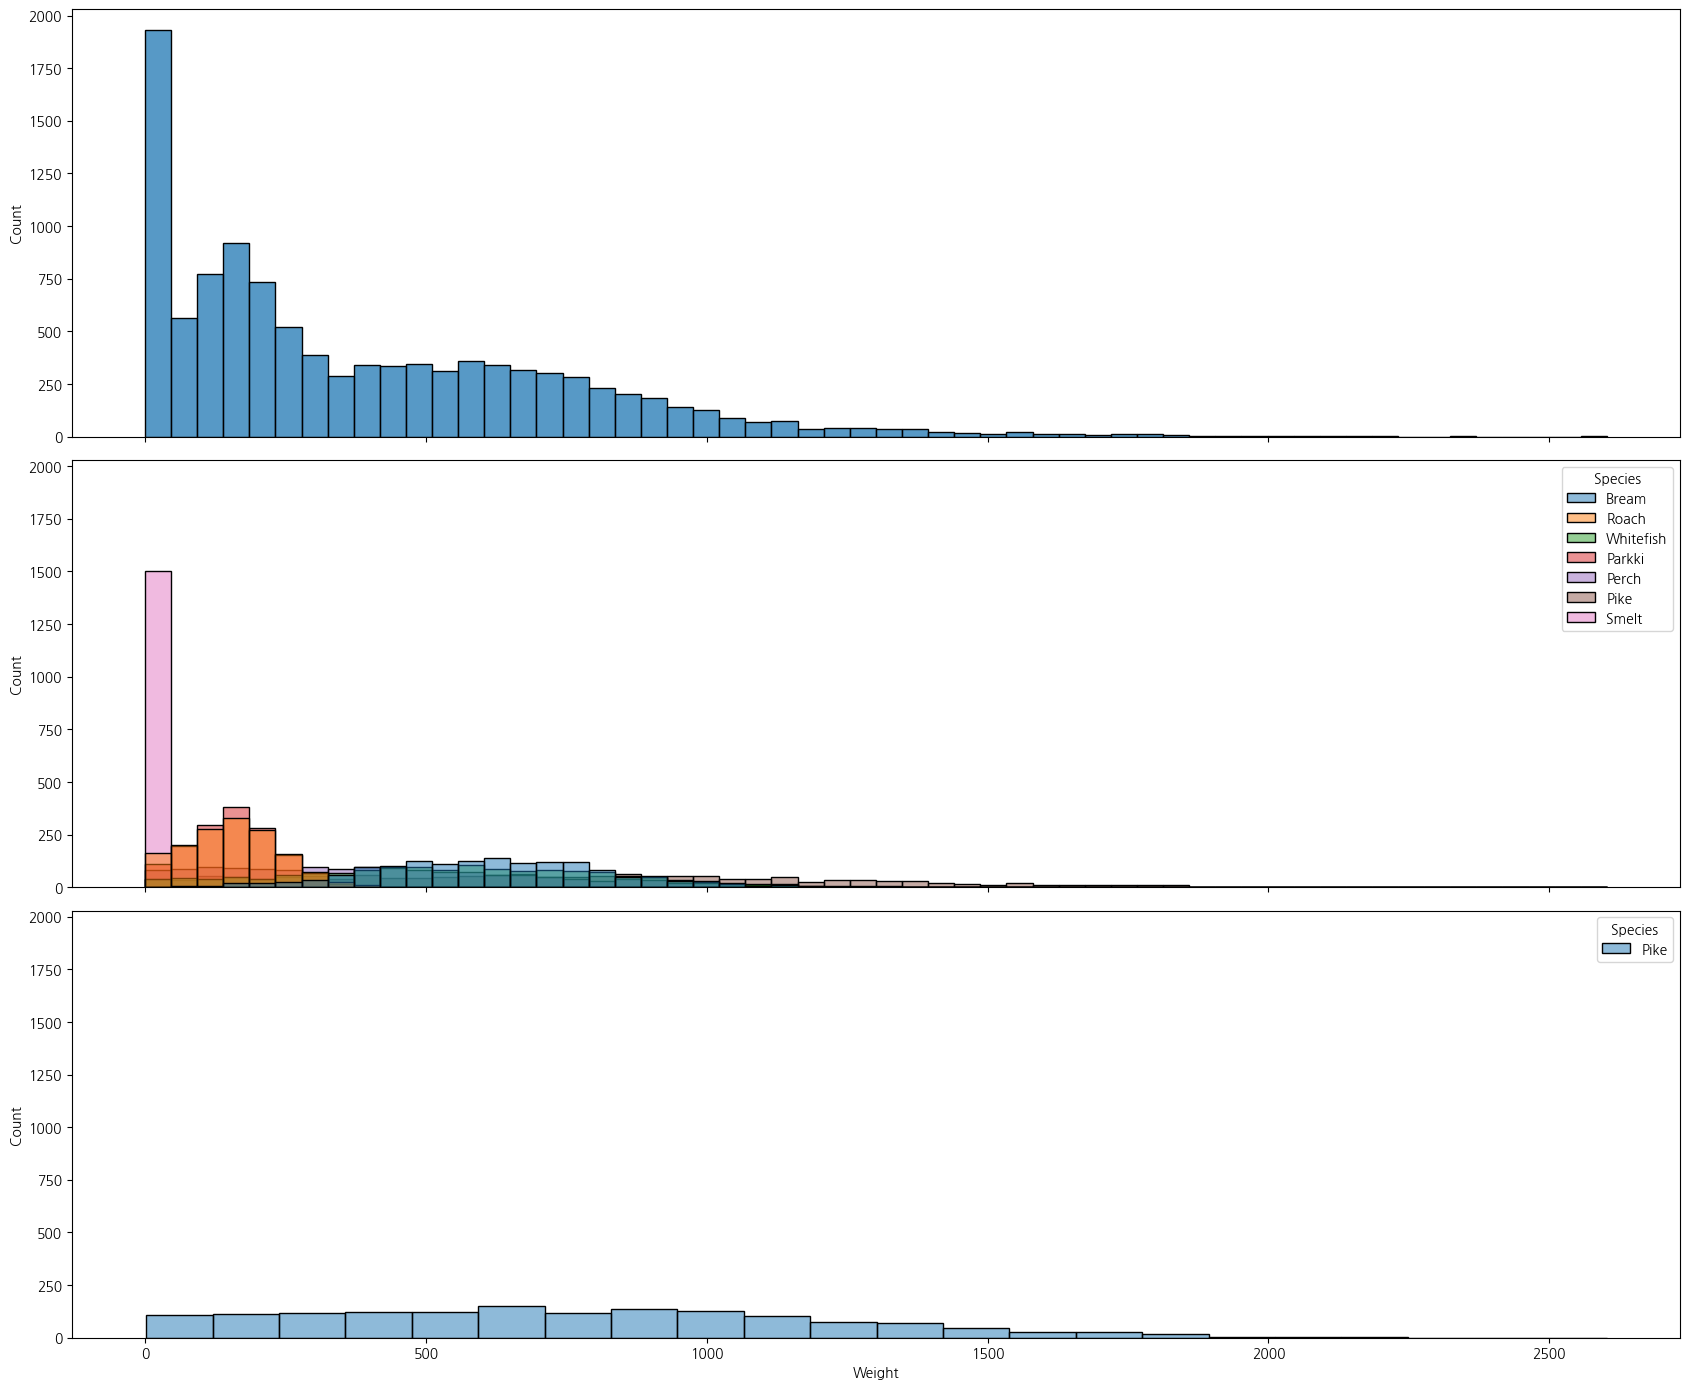

In [38]:
# -------------------------------------------------------------
# [2-2] 컬럼별 기술 통계 확인
# -------------------------------------------------------------
# === 기술 통계 확인 결과 ===
descriptive_statistics(fishDF)

# -------------------------------------------------------------
# === 히스토그램 시각화 ===
# -------------------------------------------------------------
pikeDF = fishDF[fishDF['Species'] == 'Pike']

fig, axes = plt.subplots(3, 1, figsize=(17, 14), sharex=True, sharey=True)  

sns.histplot(data=fishDF, x='Weight', ax=axes[0])
sns.histplot(data=fishDF, x='Weight', hue='Species', ax=axes[1])
sns.histplot(data=pikeDF, x='Weight', hue='Species', ax=axes[2])

plt.tight_layout()
plt.show()

=== 결측치 확인 ===
Weight      0
Length      0
Diagonal    0
Height      0
Width       0
Species     0
dtype: int64

=== 중복값 확인 ===
0

=== 중복 데이터 확인 === 
Empty DataFrame
Columns: [Weight, Length, Diagonal, Height, Width, Species]
Index: []

=== 이상치 데이터 확인 ===


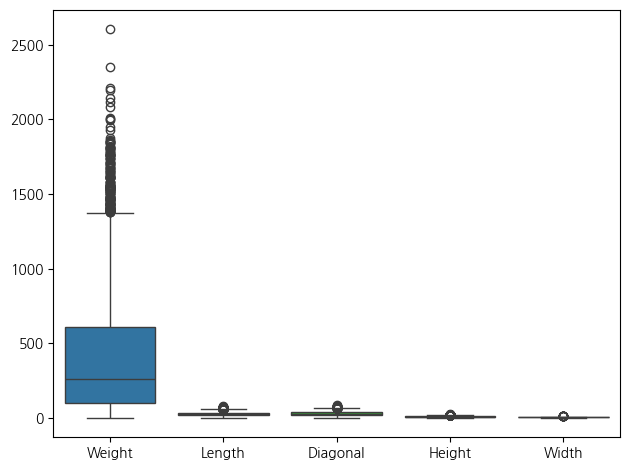

In [39]:
# -------------------------------------------------------------
# [2-3] 결측치/이상치/중복값 확인
# -------------------------------------------------------------
check_data_quality(fishDF)

# --- 확인 결과 --- 
#     결측치 X      
#     중복값 X  
#     이상치 O   
# ----------------

In [40]:
# -------------------------------------------------------------
# [2-4] 전처리 수행
# -------------------------------------------------------------
# 이상치 분석
analysis_outlier(fishDF)
# -------------------------------------------------------------
# 요주의 컬럼   : Weight(물고기의 무게)
# 요주의 물고기 : Pike(민물꼬치고기)
# -------------------------------------------------------------
# Pike(민물꼬치고기)의 무게가 천차만별인 이유
# 암컷과 수컷의 극심한 무게 차이
# -> Pike의 암컷: 산란 시즌 전에 생식소(알주머니)가 전체 체중의 16-19%를 차지해서 수컷보다 최대 9% 더 무겁고, 산란 후 약 10% 체중이 감소
#    반면 수컷은 생식소가 4% 정도만 증가해서 무게 변화가 거의 없어서, 같은 길이의 암수도 무게 차이가 극심함
# -------------------------------------------------------------
# → 평균과 중앙값의 차이: 차이가 꽤 남(124.75)
# → 왜도: 양의 왜도 (1.167)
# → 첨도: 양의 첨도 (1.352)
#   = 즉, 무게가 낮은 물고기가 다수이고 무게가 높은 물고기고 소수 존재함
#   = 현실적으로 봤을 때도 매우 무거운 물고기가 대체적으로 소수이므로 말이 된다고 생각!

=== 이상치 분석 ===
【Weight】 범위: [-663.36, 1376.08]
  이상치: 159개 (상한: 159, 하한: 0)

【Length】 범위: [-3.51, 57.31]
  이상치: 181개 (상한: 181, 하한: 0)

【Diagonal】 범위: [-3.92, 63.73]
  이상치: 114개 (상한: 114, 하한: 0)

【Height】 범위: [-0.93, 17.55]
  이상치: 163개 (상한: 163, 하한: 0)

【Width】 범위: [-0.66, 9.11]
  이상치: 14개 (상한: 14, 하한: 0)



[3] 데이터 전처리 및 학습 준비 <hr>

In [41]:
# ----------------------------------------------------------------------------------------
# [3-1] 품종컬럼 자료형 변환
# ----------------------------------------------------------------------------------------
pd.options.mode.copy_on_write = True
fishDF.Species = fishDF.Species.astype('category')
print(fishDF.info(), '\n')

# ----------------------------------------------------------------------------------------
# [3-2] 피쳐 선정
# ----------------------------------------------------------------------------------------
# 피쳐 선정 - 상관계수상 가장 높은 수치를 띄는 Diagonal(대각선), Length(길이)
#          - 학습 시키는 의미가 없다고 생각을 해서 Diagonal(대각선) 컬럼을 버리고 총 4개의 컬럼을 피쳐로 사용
print(f"=== 상관계수 재확인 ===\n{fishDF.iloc[:, :-1].corr()}\n")
# sns.scatterplot(data=fishDF, x='Diagonal', y='Length', hue='Species')

# ----------------------------------------------------------------------------------------
# [3-3] 피쳐와 타겟 분리
# ----------------------------------------------------------------------------------------
featureDF = fishDF[['Weight', 'Length', 'Height', 'Width']]
targetSR = fishDF[fishDF.columns[-1]]
print(f"featureDF : {featureDF.shape}, targetSR : {targetSR.shape}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10500 entries, 0 to 10499
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Weight    10500 non-null  float64 
 1   Length    10500 non-null  float64 
 2   Diagonal  10500 non-null  float64 
 3   Height    10500 non-null  float64 
 4   Width     10500 non-null  float64 
 5   Species   10500 non-null  category
dtypes: category(1), float64(5)
memory usage: 420.9 KB
None 

=== 상관계수 재확인 ===
            Weight    Length  Diagonal    Height     Width
Weight    1.000000  0.910209  0.911204  0.654831  0.847653
Length    0.910209  1.000000  0.996706  0.617080  0.865005
Diagonal  0.911204  0.996706  1.000000  0.665658  0.876708
Height    0.654831  0.617080  0.665658  1.000000  0.814584
Width     0.847653  0.865005  0.876708  0.814584  1.000000

featureDF : (10500, 4), targetSR : (10500,)


In [42]:
# -------------------------------------------------------------
# [3-4] 피쳐(수치형) 스케일링
# -------------------------------------------------------------
# 1. 스케일링을 해야 할까?
print(featureDF.describe(), '\n')
# Length   = 0.337 ~ 79.486(79.149 범위)(std=11.65)
# Diagonal = 0.731 ~ 85.080(84.349 범위)(std=12.4987)
# Length와 Diagonal의 범위/std 너무 큼(데이터 넓게 퍼지고 값도 큼) 
# → 스케일링 작업을 통해 균등하게 맞춤

# 2. 스케일러 생성
std_scaler = StandardScaler()
std_scaler.fit(featureDF)

feature_scaled = std_scaler.transform(featureDF)

# 3. 스케일링 결과 확인(원본 vs 스케일링)
print(featureDF[:5], '\n')
print(feature_scaled[:5])

             Weight        Length        Height         Width
count  10500.000000  10500.000000  10500.000000  10500.000000
mean     382.374387     27.493283      8.382004      4.139189
std      356.871452     11.652432      4.020338      1.737586
min        0.022947      0.337029      0.206650      0.048801
25%      101.429476     19.301808      5.999904      3.007157
50%      257.622011     26.315113      8.193073      4.190599
75%      611.290132     34.507064     10.618332      5.448763
max     2602.490537     79.486123     22.535982     10.562539 

       Weight     Length     Height     Width
0  487.423341  32.423746  14.591014  5.270922
1  990.896538  41.365270  18.719116  7.000605
2  627.081718  33.444702  15.463397  5.670238
3  749.382720  35.686411  15.974293  6.036774
4  615.621949  33.527752  15.502285  5.483102 

[[0.29437478 0.42314759 1.5444734  0.65135636]
 [1.70523903 1.19053668 2.57132704 1.64685539]
 [0.68573427 0.51076914 1.76147615 0.8811781 ]
 [1.02845383 0.703159

[4] 교차검증 <HR>

In [43]:
# ----------------------------------------------------
# [4-1] cross_validate() 함수 사용
# ----------------------------------------------------
# 모델 인스턴스 생성
MAX_N = 100

resultDF = pd.DataFrame(columns=['Neighbors', 'fit_time', 'score_time', 'test_score', 'train_score', 'diff'])

for n in range(1, MAX_N):
    # 1. 모델 생성
    k_model = KNeighborsClassifier(n_neighbors=n)

    # 2. 교차검증 수행
    result_dict = cross_validate(
        k_model,
        feature_scaled,
        targetSR,
        return_train_score=True, # 훈련 성능도 반환
        cv=3
    )

    # 3. 평균값 계산
    fit_time_mean   = result_dict['fit_time'].mean()
    score_time_mean = result_dict['score_time'].mean()
    test_mean       = result_dict['test_score'].mean()
    train_mean      = result_dict['train_score'].mean()

    # 4. diff 계산
    diff = abs(train_mean - test_mean)

    # 5. DF에 추가
    row = [n, fit_time_mean, score_time_mean, test_mean, train_mean, diff]
    resultDF.loc[len(resultDF)] = row

,Neighbors,fit_time,score_time,test_score,train_score,diff
0,1.0,0.002692,0.016278,0.934286,1.000000,0.065714
1,2.0,0.003353,0.017206,0.931238,0.973667,0.042429
2,3.0,0.006900,0.011704,0.941143,0.966524,0.025381
3,4.0,0.010780,0.014345,0.943048,0.963762,0.020714
4,5.0,0.005107,0.018058,0.942857,0.959095,0.016238
5,6.0,0.005556,0.018087,0.944190,0.959143,0.014952
6,7.0,0.000000,0.018578,0.941238,0.953762,0.012524
7,8.0,0.006930,0.021230,0.944286,0.954905,0.010619
8,9.0,0.008742,0.014235,0.940952,0.952333,0.011381
9,10.0,0.011094,0.017975,0.942190,0.953190,0.011000


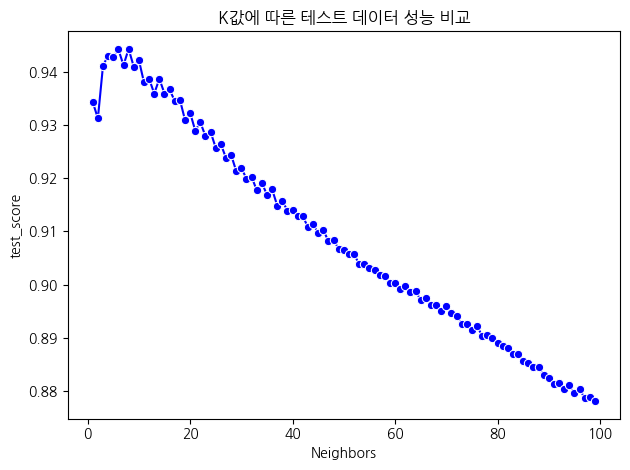

In [53]:
# n_neighbors값에 따른 성능 비교
# resultDF.sort_values(by=['diff', 'Neighbors'], inplace=True)
resultDF.sort_values(by='Neighbors', inplace=True)
display(resultDF.head(20))

# 성능 시각화
sns.lineplot(data=resultDF, x='Neighbors', y='test_score', marker='o', color='blue')
plt.title("K값에 따른 테스트 데이터 성능 비교")
plt.tight_layout()
plt.show()

#### 최적의 Hyper-Parameter : 7

[5] 최종 모델 생성 <hr>

In [54]:
# --------------------------------------------------------------
# [5-1] 전체 학습용 데이터셋과 결정된 하이퍼파라미터로 설정된 모델 생성
# --------------------------------------------------------------
# 테스트 데이터 준비
test_feature = testDF[['Weight', 'Length', 'Height', 'Width']]
test_target = testDF[testDF.columns[-1]]

# 테스트 데이터 스케일링
std_scaler2 = StandardScaler()
std_scaler2.fit(test_feature)

test_feature_scaled = std_scaler2.transform(test_feature)
# --------------------------------------------------------------
# [5-2] 최종 모델
# --------------------------------------------------------------
# 1. 최종모델 생성
final_model = KNeighborsClassifier(n_neighbors=3)

# 2. 최종모델 훈련
final_model.fit(feature_scaled, targetSR)

# 3. 테스트 데이터로 최종모델 성능 평가
final_model.score(test_feature_scaled, test_target)

0.9666666666666667

[6] 데이터 예측 <hr>

In [56]:
# 물고기의 길이/대각선 ==> 품종 예측
in_data = input("물고기의 길이와 대각선 입력(예:641 32 14 5):").strip().split()
in_data  = list(map(float, in_data))
print(f'new_data : {in_data}', '\n')

# DF 형식으로 저장
new_data = pd.DataFrame([in_data], columns=['Weight', 'Length', 'Height', 'Width'])

# 인풋 데이터 스케일링
std_scaler3 = StandardScaler()
std_scaler3.fit(new_data)

new_data_scaled = std_scaler2.transform(new_data)

# 예측 진행
pre_target = final_model.predict(new_data_scaled)
proba_ = final_model.predict_proba(new_data_scaled)  # 예측 확률

for i, s in enumerate(['Bream', 'Roach', 'Whitefish', 'Parkki', 'Perch', 'Pike', 'Smelt']):
    print(f"{s} => {proba_[0][i]*100:.2f}%")

print(f'무게 {in_data[0]}, 길이 {in_data[1]} 높이 {in_data[2]} 너비 {in_data[3]} 물고기는 {pre_target.item()}입니다.')

new_data : [641.0, 32.0, 14.0, 5.0] 

Bream => 100.00%
Roach => 0.00%
Whitefish => 0.00%
Parkki => 0.00%
Perch => 0.00%
Pike => 0.00%
Smelt => 0.00%
무게 641.0, 길이 32.0 높이 14.0 너비 5.0 물고기는 Bream입니다.


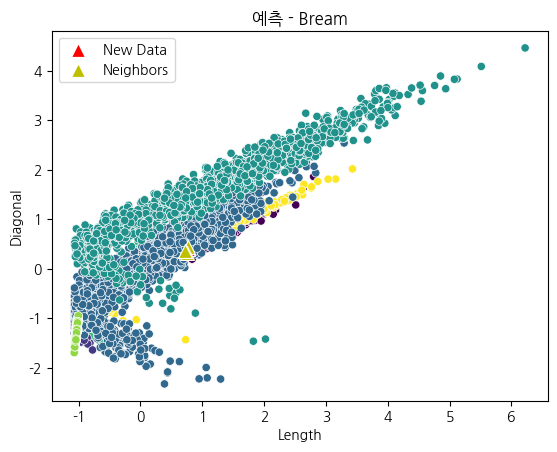

In [57]:
## 예측 검사
_, sIndices = final_model.kneighbors(new_data_scaled)

## 시각화 
# 1. 전체 데이터 시각화 (기존: plt.scatter)
# x=Length(0번째 컬럼), y=Diagonal(1번째 컬럼)
sns.scatterplot(x=feature_scaled[:, 0], y=feature_scaled[:, 1], c=targetSR.cat.codes)

# 2. 새로운 데이터 (기존: plt.plot(..., '^r'))
# marker='^' (삼각형), color='red', s=100 (마커 크기 조정, 필요시 조절)
sns.scatterplot(x=[new_data_scaled[0][0]], y=[new_data_scaled[0][1]], 
                marker='^', color='red', s=100, label='New Data')

# 3. 이웃 데이터 (기존: loop 내 plt.plot(..., '^y'))
# 반복문 대신 슬라이싱을 사용하여 한 번에 그리는 것이 Seaborn에서 더 효율적입니다.
nIdx = sIndices[0]
sns.scatterplot(x=feature_scaled[nIdx, 0], y=feature_scaled[nIdx, 1], 
                marker='^', color='y', s=100, label='Neighbors')

plt.xlabel('Length')
plt.ylabel('Diagonal')
plt.title(f'예측 - {pre_target.item()}')
plt.legend() # 범례 표시
plt.show()